In [1]:
# train a classical generative adversarial network on a gaussian probability distribution
import numpy as np
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential, model_from_json
from keras.optimizers import Adagrad
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Dropout, Reshape, LeakyReLU, Flatten, BatchNormalization
from matplotlib import pyplot

In [6]:
# define the standalone discriminator model
def define_discriminator(n_inputs=1, alpha=0.2, dropout=0.2):
    model = Sequential()
        
    model.add(Dense(200, use_bias=False, input_dim=n_inputs))
    model.add(Reshape((10,10,2)))
    
    model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_normal'))
    model.add(LeakyReLU(alpha=alpha))
    
    model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_normal'))
    model.add(LeakyReLU(alpha=alpha))

    model.add(Conv2D(16, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_normal'))
    model.add(LeakyReLU(alpha=alpha))

    model.add(Conv2D(8, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_normal'))

    model.add(Flatten())
    model.add(LeakyReLU(alpha=alpha))
    model.add(Dropout(dropout)) 

    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    opt = Adagrad(learning_rate=0.01)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs=1, alpha=0.2):
    model = Sequential()

    model.add(Dense(200, input_dim=latent_dim, kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))
    model.add(Reshape((10,10,2)))

    model.add(Conv2DTranspose(32, kernel_size=2, strides=1, padding=('same'), use_bias=False, kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))

    model.add(Conv2DTranspose(16, kernel_size=2, strides=1, padding=('same'), use_bias=False, kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))

    model.add(Conv2DTranspose(8, kernel_size=3, strides=1, padding=('same'), use_bias=False, kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))

    model.add(Flatten())

    model.add(Dense(n_outputs, activation='tanh'))
    
    return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = Adagrad(learning_rate=0.01)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model
 
# generate real samples with class labels
def generate_real_samples(samples, sigma=0.25, mu=0.0):
    # generate samples from the distribution
    s = np.random.normal(mu, sigma, samples)
    # shape array
    X = s.reshape(samples, 1)
    # generate class labels
    y = np.ones((samples, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, samples):
    # generate points in the latent space
    x_input = randn(latent_dim * samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(samples, latent_dim)
    return x_input
 
# use the generator to generate fake examples, with class labels
def generate_fake_samples(generator, latent_dim, samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, samples)
    # predict outputs
    X = generator.predict(x_input)
    # shape array
    X = X.reshape(samples, 1)
    # create class labels
    y = np.zeros((samples, 1))
    return X, y
 
# evaluate the discriminator and plot real and fake samples
def summarize_performance(epoch, generator, discriminator, latent_dim, samples, nbins, d_loss, g_loss):
    # prepare real samples
    x_real, y_real = generate_real_samples(100000)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, 100000)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('epoch: ',epoch, 'acc_real: ', acc_real, 'acc_fake: ', acc_fake)
    # histogram plot real and fake data points
    pyplot.hist(x_real, np.linspace(-1.0, 1.0, nbins+1), color='red', label='real', alpha=0.5)
    pyplot.hist(x_fake, np.linspace(-1.0, 1.0, nbins+1), color='blue', label='fake', alpha=0.5)
    #yplot.hist(x_real, color='red', label='real', alpha=0.5)
    #yplot.hist(x_fake, color='blue', label='fake', alpha=0.5)
    pyplot.legend()
    pyplot.show()

    # plot loss generator and discriminator
    pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), g_loss, label='generator')
    pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), d_loss, label='discriminator')
    pyplot.legend()
    pyplot.show()  

    # serialize weights to HDF5
    generator.save_weights(str(epoch)+"_generator.h5")
    print("Saved generator to disk")
    discriminator.save_weights(str(epoch)+"_discriminator.h5")
    print("Saved discriminator to disk")
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=30000, samples=128, nbins=49, n_eval=250):
    d_loss = []
    g_loss = []
    # determine half the size of one batch, for updating the discriminator
    half_samples = int(samples / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_samples)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_samples)
        # update discriminator
        d_model.trainable = True
        d_loss_real, _ = d_model.train_on_batch(x_real, y_real)
        d_loss_fake, _ = d_model.train_on_batch(x_fake, y_fake)
        d_loss.append((d_loss_real + d_loss_fake)/2)        
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, samples)
        # create inverted labels for the fake samples
        y_gan = np.ones((samples, 1))
        # update the generator via the discriminator's error
        g_loss_fake = gan_model.train_on_batch(x_gan, y_gan)
        g_loss.append(g_loss_fake)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim, samples, nbins, d_loss, g_loss)

epoch:  249 acc_real:  0.9376400113105774 acc_fake:  0.25722000002861023


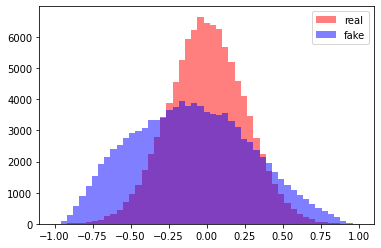

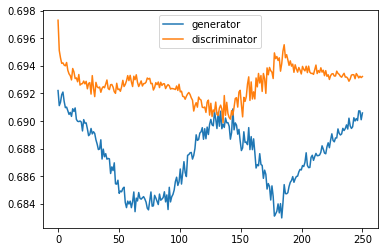

Saved generator to disk
Saved discriminator to disk
epoch:  499 acc_real:  0.8777999877929688 acc_fake:  0.09193000197410583


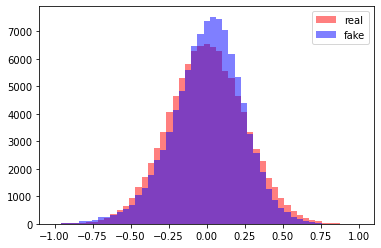

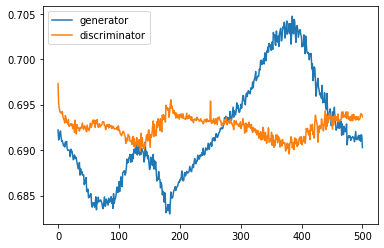

Saved generator to disk
Saved discriminator to disk
epoch:  749 acc_real:  0.9835600256919861 acc_fake:  0.00675999978557229


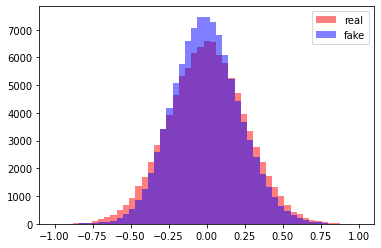

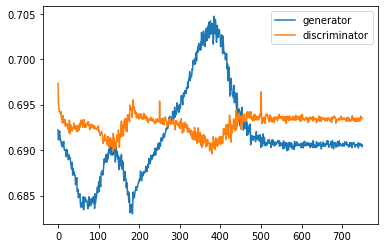

Saved generator to disk
Saved discriminator to disk
epoch:  999 acc_real:  0.9945399761199951 acc_fake:  0.001339999958872795


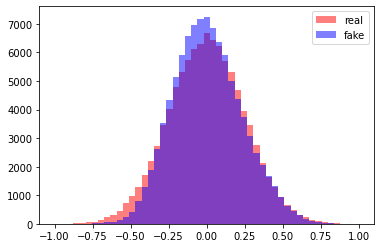

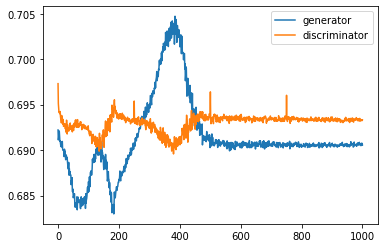

Saved generator to disk
Saved discriminator to disk
epoch:  1249 acc_real:  0.9963600039482117 acc_fake:  0.0006799999973736703


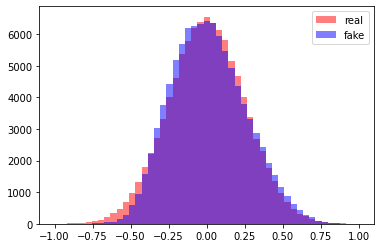

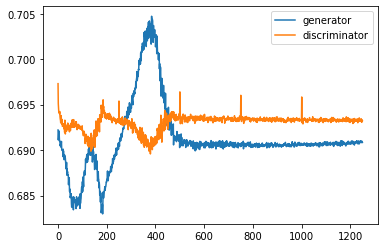

Saved generator to disk
Saved discriminator to disk
epoch:  1499 acc_real:  0.997730016708374 acc_fake:  0.0004400000034365803


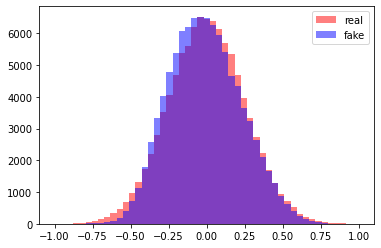

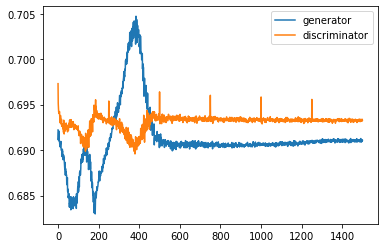

Saved generator to disk
Saved discriminator to disk
epoch:  1749 acc_real:  0.9980999827384949 acc_fake:  0.00026000000070780516


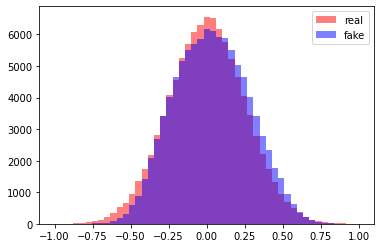

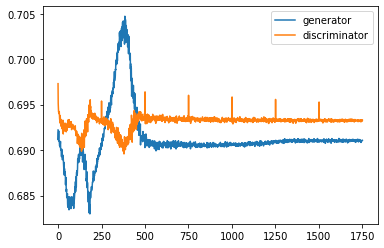

Saved generator to disk
Saved discriminator to disk
epoch:  1999 acc_real:  0.9991899728775024 acc_fake:  9.000000136438757e-05


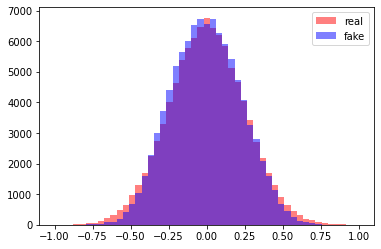

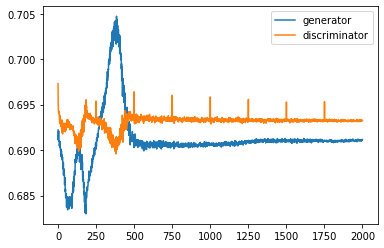

Saved generator to disk
Saved discriminator to disk
epoch:  2249 acc_real:  0.9995200037956238 acc_fake:  4.999999873689376e-05


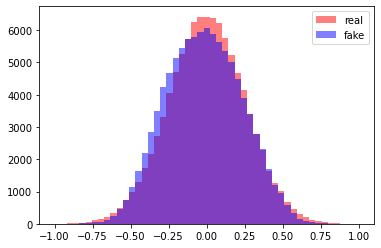

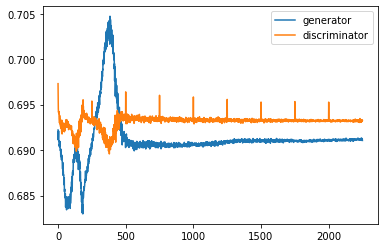

Saved generator to disk
Saved discriminator to disk
epoch:  2499 acc_real:  0.9994400143623352 acc_fake:  2.9999999242136255e-05


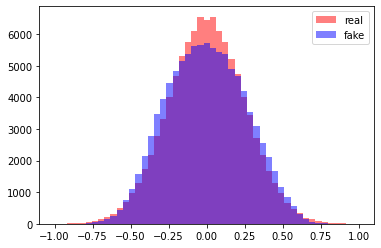

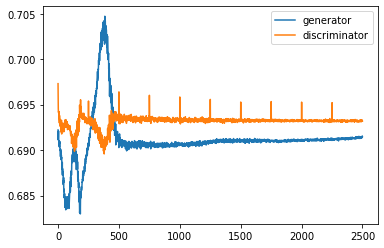

Saved generator to disk
Saved discriminator to disk
epoch:  2749 acc_real:  0.9991499781608582 acc_fake:  5.999999848427251e-05


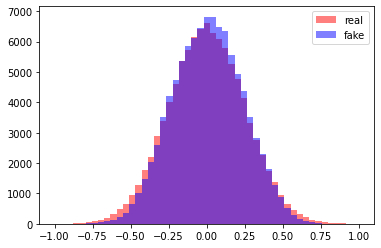

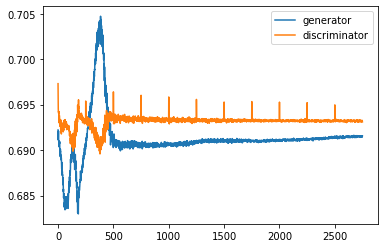

Saved generator to disk
Saved discriminator to disk
epoch:  2999 acc_real:  0.999239981174469 acc_fake:  9.999999747378752e-06


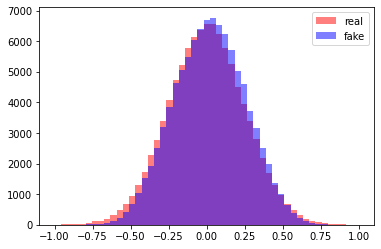

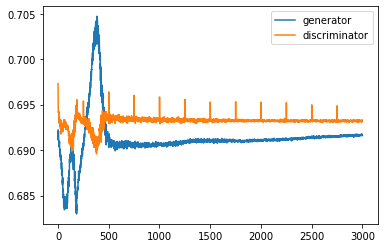

Saved generator to disk
Saved discriminator to disk
epoch:  3249 acc_real:  0.999210000038147 acc_fake:  0.0002500000118743628


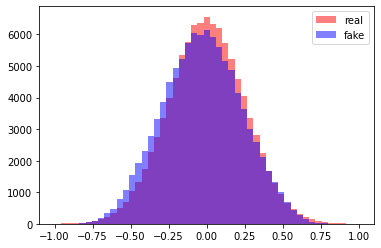

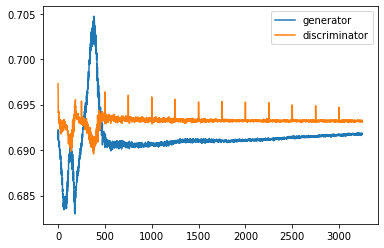

Saved generator to disk
Saved discriminator to disk
epoch:  3499 acc_real:  0.9993199706077576 acc_fake:  7.000000186963007e-05


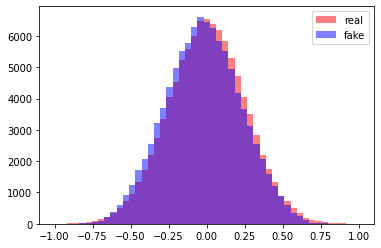

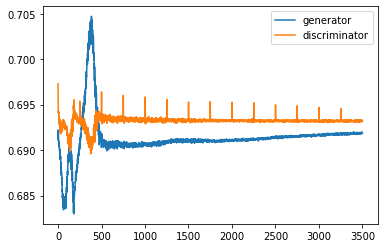

Saved generator to disk
Saved discriminator to disk
epoch:  3749 acc_real:  0.9993699789047241 acc_fake:  7.000000186963007e-05


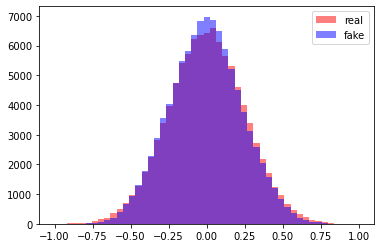

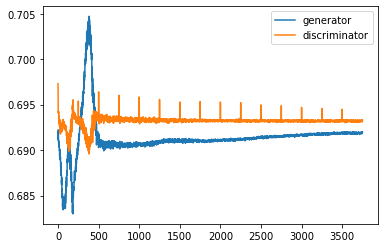

Saved generator to disk
Saved discriminator to disk
epoch:  3999 acc_real:  0.9995099902153015 acc_fake:  2.9999999242136255e-05


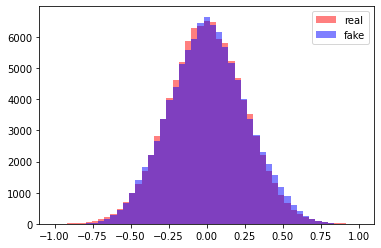

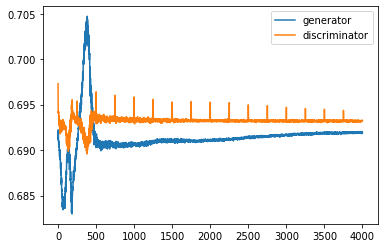

Saved generator to disk
Saved discriminator to disk
epoch:  4249 acc_real:  0.9995999932289124 acc_fake:  0.0


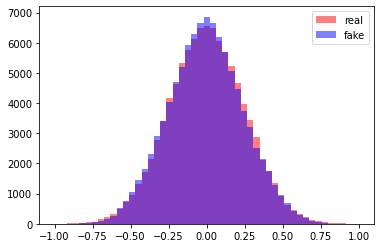

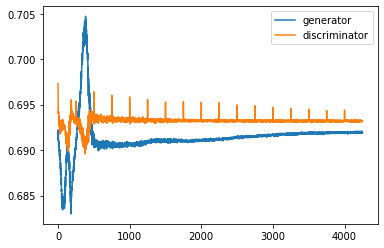

Saved generator to disk
Saved discriminator to disk
epoch:  4499 acc_real:  0.9996200203895569 acc_fake:  4.999999873689376e-05


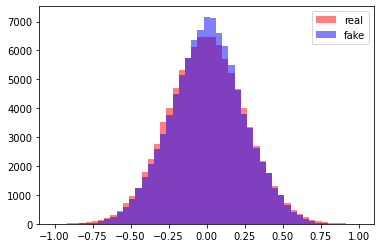

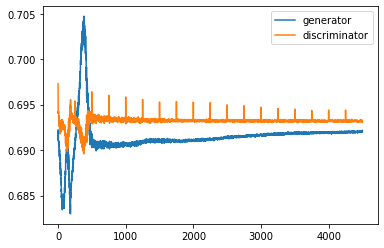

Saved generator to disk
Saved discriminator to disk
epoch:  4749 acc_real:  0.9996100068092346 acc_fake:  9.999999747378752e-06


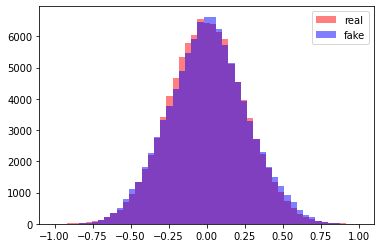

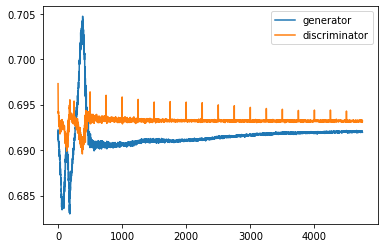

Saved generator to disk
Saved discriminator to disk
epoch:  4999 acc_real:  0.9995899796485901 acc_fake:  0.00011999999696854502


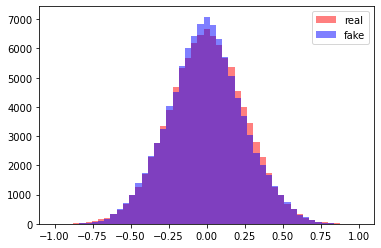

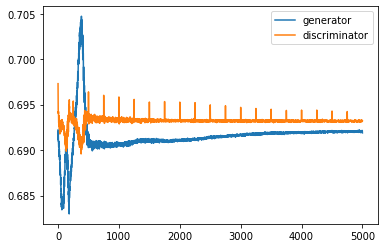

Saved generator to disk
Saved discriminator to disk
epoch:  5249 acc_real:  0.9995999932289124 acc_fake:  4.999999873689376e-05


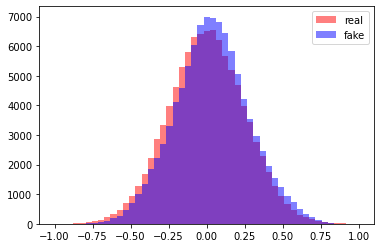

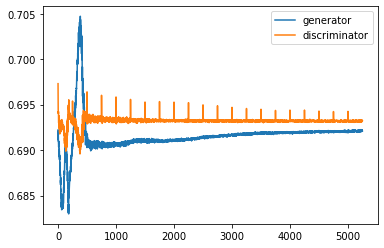

Saved generator to disk
Saved discriminator to disk
epoch:  5499 acc_real:  0.9997299909591675 acc_fake:  2.9999999242136255e-05


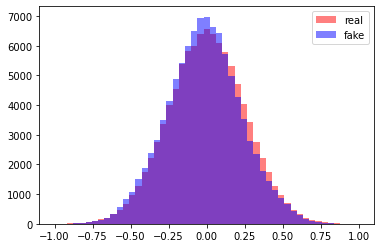

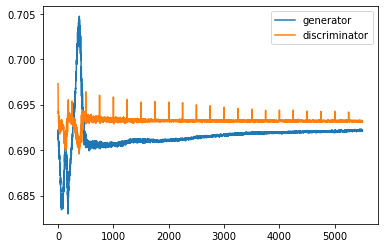

Saved generator to disk
Saved discriminator to disk
epoch:  5749 acc_real:  0.9998499751091003 acc_fake:  0.0


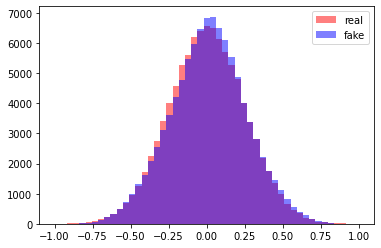

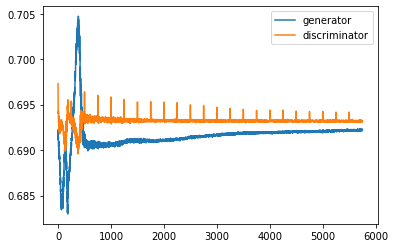

Saved generator to disk
Saved discriminator to disk
epoch:  5999 acc_real:  0.9996700286865234 acc_fake:  5.999999848427251e-05


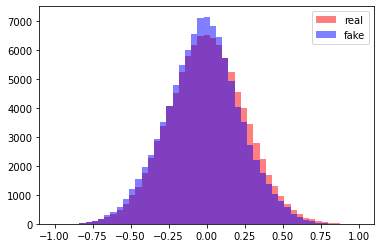

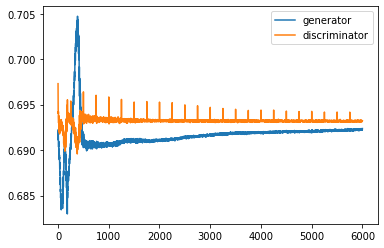

Saved generator to disk
Saved discriminator to disk
epoch:  6249 acc_real:  0.9996500015258789 acc_fake:  9.000000136438757e-05


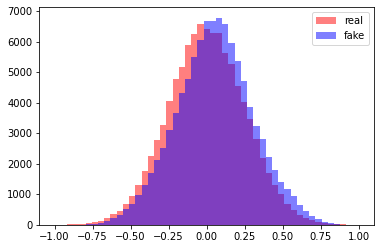

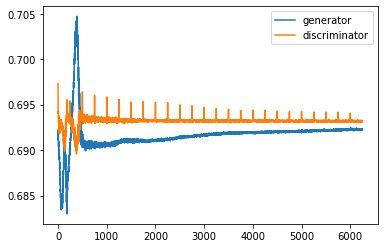

Saved generator to disk
Saved discriminator to disk
epoch:  6499 acc_real:  0.9996500015258789 acc_fake:  4.999999873689376e-05


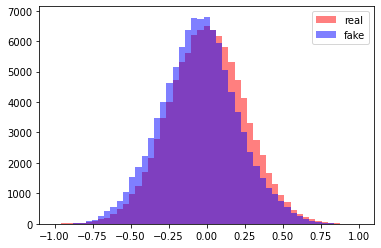

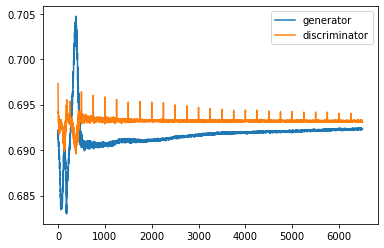

Saved generator to disk
Saved discriminator to disk
epoch:  6749 acc_real:  0.999530017375946 acc_fake:  5.999999848427251e-05


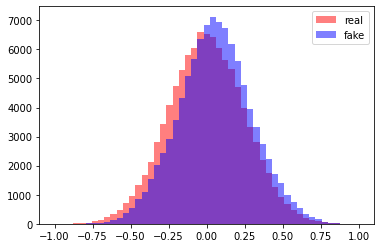

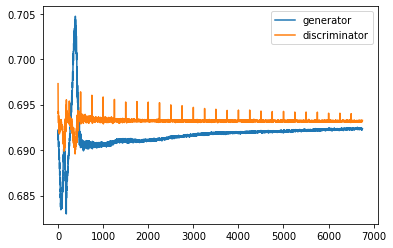

Saved generator to disk
Saved discriminator to disk
epoch:  6999 acc_real:  0.9995700120925903 acc_fake:  0.00019999999494757503


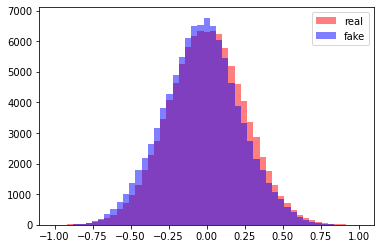

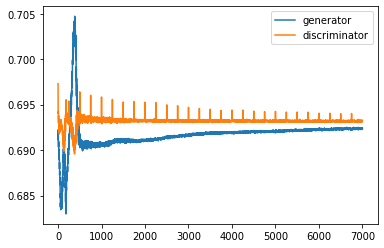

Saved generator to disk
Saved discriminator to disk
epoch:  7249 acc_real:  0.9993600249290466 acc_fake:  0.0001900000061141327


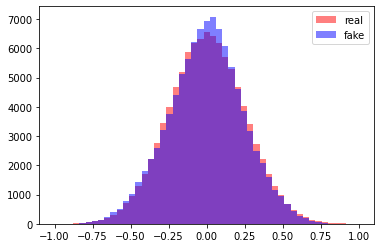

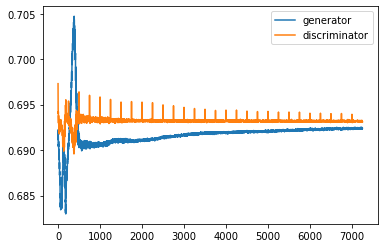

Saved generator to disk
Saved discriminator to disk
epoch:  7499 acc_real:  0.9993900060653687 acc_fake:  0.0002800000074785203


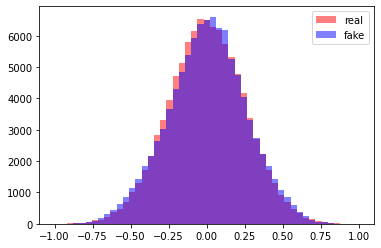

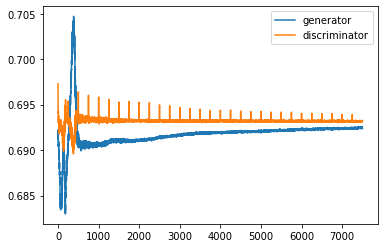

Saved generator to disk
Saved discriminator to disk
epoch:  7749 acc_real:  0.9994400143623352 acc_fake:  0.0001500000071246177


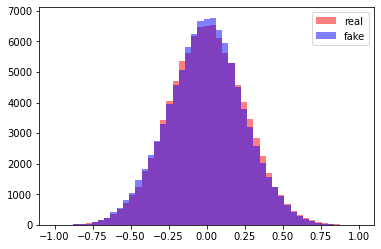

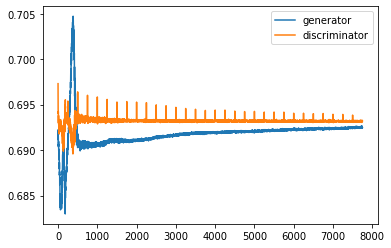

Saved generator to disk
Saved discriminator to disk
epoch:  7999 acc_real:  0.9989200234413147 acc_fake:  0.0002800000074785203


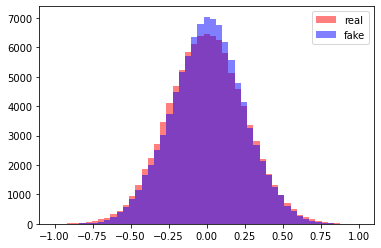

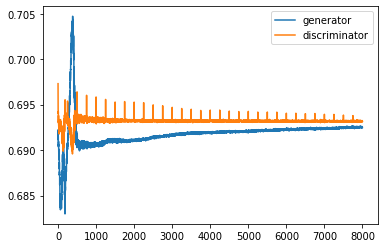

Saved generator to disk
Saved discriminator to disk
epoch:  8249 acc_real:  0.999180018901825 acc_fake:  0.00015999999595806003


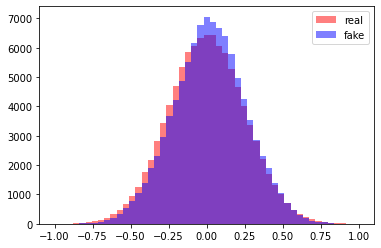

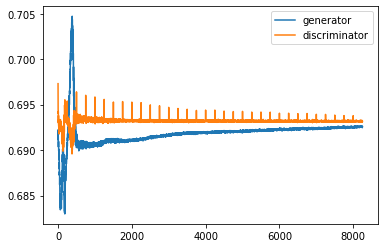

Saved generator to disk
Saved discriminator to disk
epoch:  8499 acc_real:  0.9994800090789795 acc_fake:  0.0002300000051036477


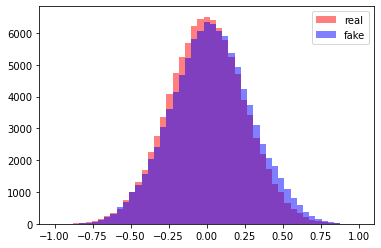

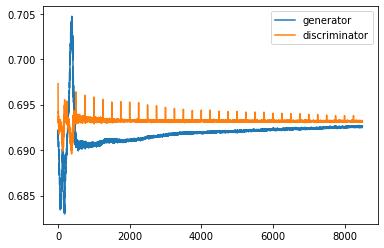

Saved generator to disk
Saved discriminator to disk
epoch:  8749 acc_real:  0.9988300204277039 acc_fake:  0.0003699999942909926


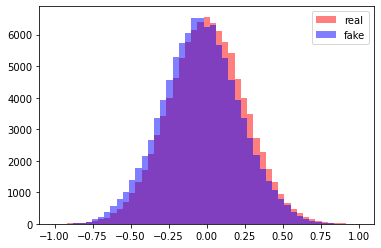

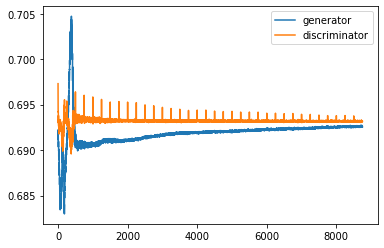

Saved generator to disk
Saved discriminator to disk
epoch:  8999 acc_real:  0.9991400241851807 acc_fake:  0.00015999999595806003


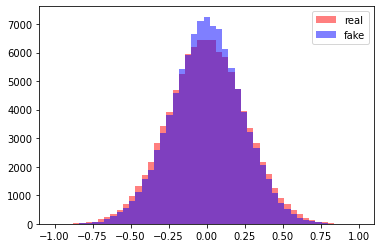

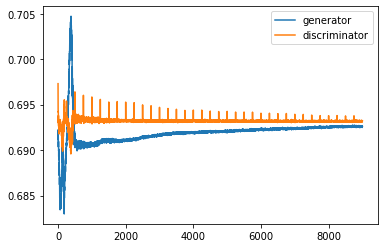

Saved generator to disk
Saved discriminator to disk
epoch:  9249 acc_real:  0.9996500015258789 acc_fake:  4.999999873689376e-05


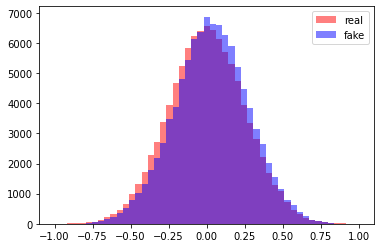

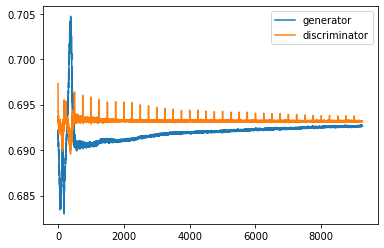

Saved generator to disk
Saved discriminator to disk
epoch:  9499 acc_real:  0.999530017375946 acc_fake:  0.00011000000085914508


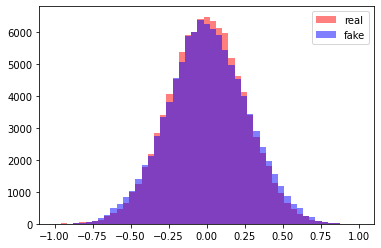

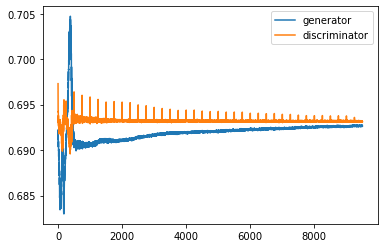

Saved generator to disk
Saved discriminator to disk
epoch:  9749 acc_real:  0.9994300007820129 acc_fake:  0.00013000000035390258


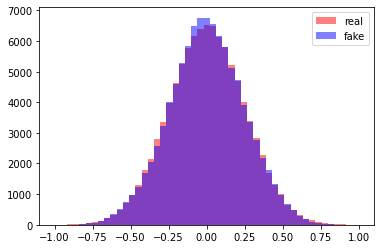

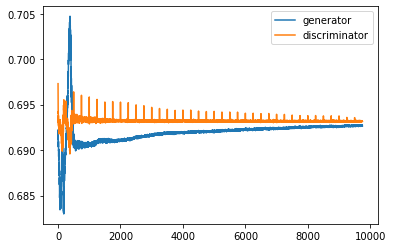

Saved generator to disk
Saved discriminator to disk
epoch:  9999 acc_real:  0.9988999962806702 acc_fake:  0.0004199999966658652


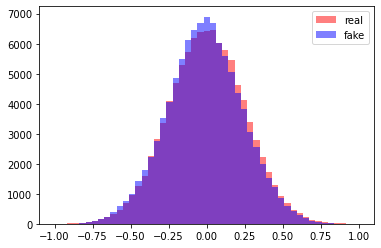

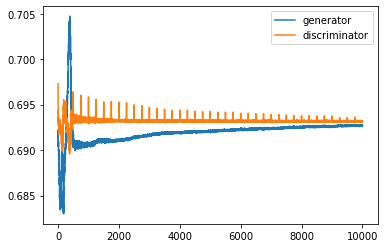

Saved generator to disk
Saved discriminator to disk
epoch:  10249 acc_real:  0.9995399713516235 acc_fake:  0.00016999999934341758


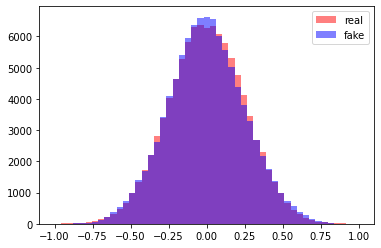

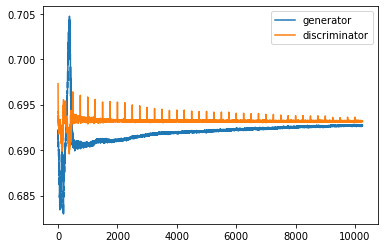

Saved generator to disk
Saved discriminator to disk
epoch:  10499 acc_real:  0.9994500279426575 acc_fake:  7.999999797903001e-05


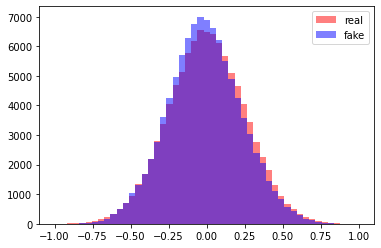

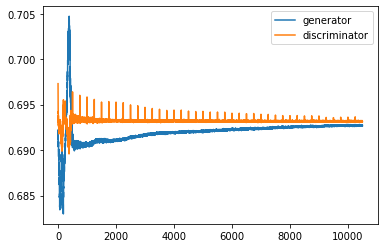

Saved generator to disk
Saved discriminator to disk
epoch:  10749 acc_real:  0.9994400143623352 acc_fake:  0.0001900000061141327


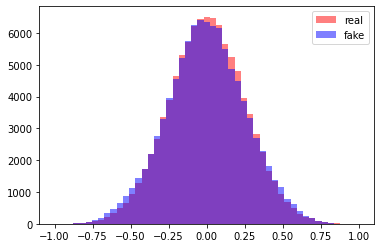

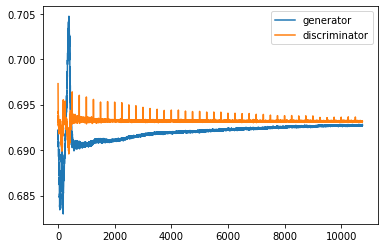

Saved generator to disk
Saved discriminator to disk
epoch:  10999 acc_real:  0.9993199706077576 acc_fake:  0.00016999999934341758


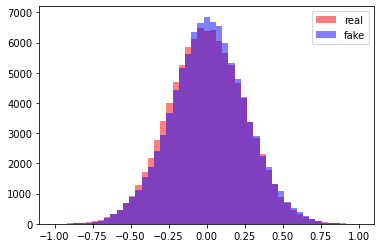

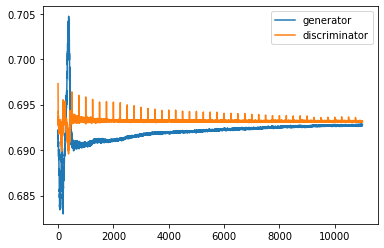

Saved generator to disk
Saved discriminator to disk
epoch:  11249 acc_real:  0.9994800090789795 acc_fake:  0.00019999999494757503


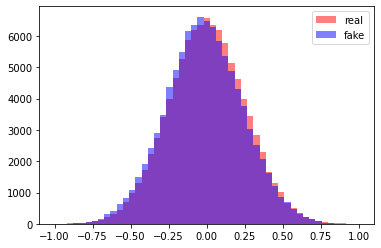

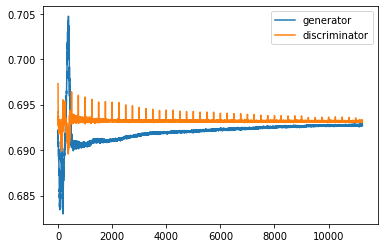

Saved generator to disk
Saved discriminator to disk
epoch:  11499 acc_real:  0.9995899796485901 acc_fake:  5.999999848427251e-05


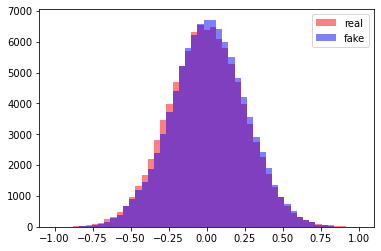

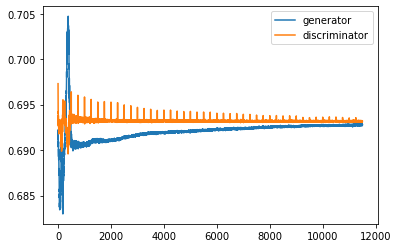

Saved generator to disk
Saved discriminator to disk
epoch:  11749 acc_real:  0.9995700120925903 acc_fake:  0.00014000000373926014


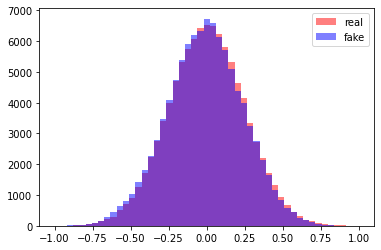

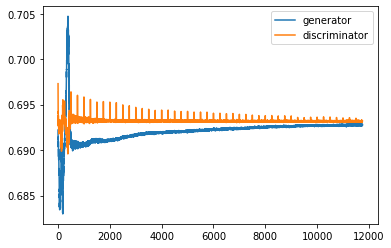

Saved generator to disk
Saved discriminator to disk
epoch:  11999 acc_real:  0.9992300271987915 acc_fake:  0.0003000000142492354


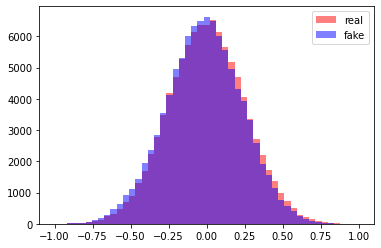

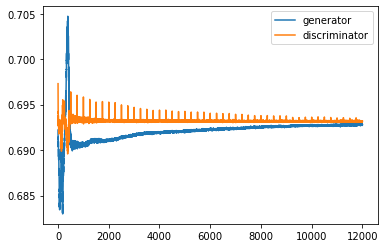

Saved generator to disk
Saved discriminator to disk
epoch:  12249 acc_real:  0.9993000030517578 acc_fake:  0.0001500000071246177


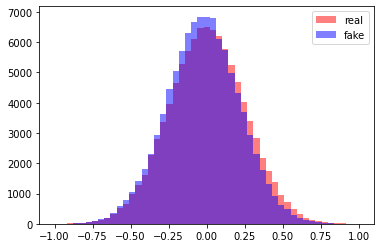

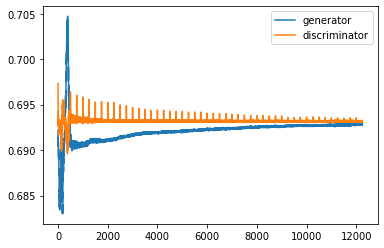

Saved generator to disk
Saved discriminator to disk
epoch:  12499 acc_real:  0.9991999864578247 acc_fake:  0.0005699999746866524


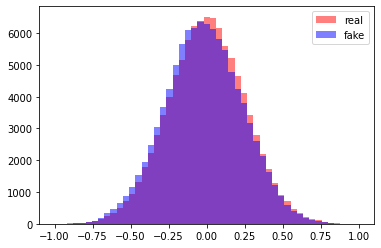

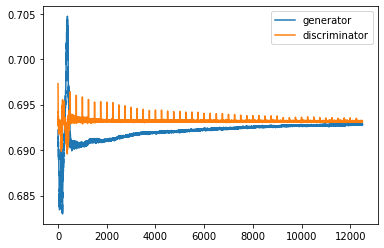

Saved generator to disk
Saved discriminator to disk
epoch:  12749 acc_real:  0.9406800270080566 acc_fake:  0.04981999844312668


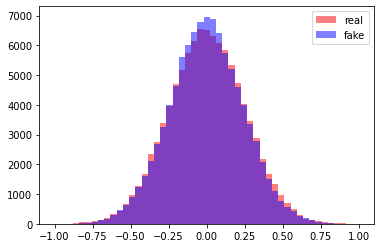

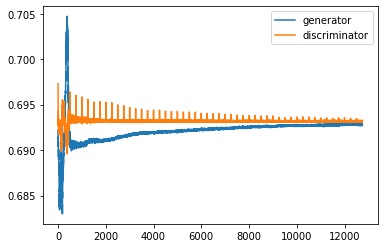

Saved generator to disk
Saved discriminator to disk
epoch:  12999 acc_real:  0.9987499713897705 acc_fake:  0.0007999999797903001


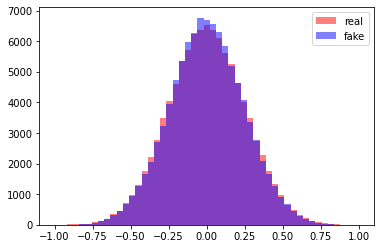

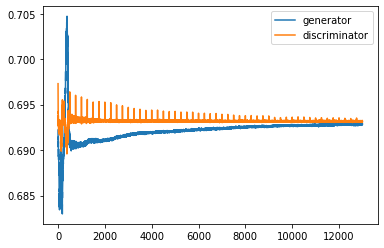

Saved generator to disk
Saved discriminator to disk


KeyboardInterrupt: ignored

In [7]:
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# serialize generator and discriminator to JSON
gen_model_json = generator.to_json()
with open("generator.json", "w") as json_file:
    json_file.write(gen_model_json)
disc_model_json = discriminator.to_json()
with open("discriminator.json", "w") as json_file:
    json_file.write(disc_model_json)
# train model
train(generator, discriminator, gan_model, latent_dim)